__Machine Learning Homework 2__

In [1]:
import numpy as np
import seaborn as sns
from itertools import product
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from IPython.display import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
import functools
import io
import sys
import numpy.lib.recfunctions as rfn

In [2]:
#to fix a bug in np.genfromtxt when Python Version (sys.version_info) is 3 or greater. 
# https://stackoverflow.com/questions/23319266/using-numpy-genfromtxt-gives-typeerror-cant-convert-bytes-object-to-str-impl
genfromtxt_old = np.genfromtxt
@functools.wraps(genfromtxt_old)
def genfromtxt_py3_fixed(f, encoding="utf-8", *args, **kwargs):
  if isinstance(f, io.TextIOBase):
    if hasattr(f, "buffer") and hasattr(f.buffer, "raw") and \
    isinstance(f.buffer.raw, io.FileIO):
      # Best case: get underlying FileIO stream (binary!) and use that
      fb = f.buffer.raw
      # Reset cursor on the underlying object to match that on wrapper
      fb.seek(f.tell())
      result = genfromtxt_old(fb, *args, **kwargs)
      # Reset cursor on wrapper to match that of the underlying object
      f.seek(fb.tell())
    else:
      # Not very good but works: Put entire contents into BytesIO object,
      # otherwise same ideas as above
      old_cursor_pos = f.tell()
      fb = io.BytesIO(bytes(f.read(), encoding=encoding))
      result = genfromtxt_old(fb, *args, **kwargs)
      f.seek(old_cursor_pos + fb.tell())
  else:
    result = genfromtxt_old(f, *args, **kwargs)
  return result

if sys.version_info >= (3,):
  np.genfromtxt = genfromtxt_py3_fixed

#http://esantorella.com/2016/06/16/groupby/
#A fast GroupBy class
class Groupby:
    def __init__(self, keys):
        _, self.keys_as_int = np.unique(keys, return_inverse = True)
        self.n_keys = max(self.keys_as_int)
        self.set_indices()
        
    def set_indices(self):
        self.indices = [[] for i in range(self.n_keys+1)]
        for i, k in enumerate(self.keys_as_int):
            self.indices[k].append(i)
        self.indices = [np.array(elt) for elt in self.indices]
        
    def apply(self, function, vector, broadcast):
        if broadcast:
            result = np.zeros(len(vector))
            for idx in self.indices:
                result[idx] = function(vector[idx])
        else:
            result = np.zeros(self.n_keys)
            for k, idx in enumerate(self.indices):
                result[self.keys_as_int[k]] = function(vector[idx])

        return result

Helpful guide
https://jakevdp.github.io/PythonDataScienceHandbook/02.09-structured-data-numpy.html  

Datatypes
https://docs.scipy.org/doc/numpy-1.12.0/reference/arrays.dtypes.html  

Genfromtext
https://docs.scipy.org/doc/numpy/user/basics.io.genfromtxt.html
Genfromtext helps bring in delimited text (like read.csv)

That being said, decision trees often perform well on imbalanced datasets. The splitting rules that look at the class variable used in the creation of the trees, can force both classes to be addressed.

If in doubt, try a few popular decision tree algorithms like C4.5, C5.0, CART, and Random Forest.

__Assignment__:  
    A medical claim is denoted by a claim number ('Claim.Number'). Each claim consists of one or more medical lines denoted by a claim line number ('Claim.Line.Number').

1. J-codes are procedure codes that start with the letter 'J'.

     A. Find the number of claim lines that have J-codes.

     B. How much was paid for J-codes to providers for 'in network' claims?

     C. What are the top five J-codes based on the payment to providers?

In [3]:
names = ["V1","Claim.Number","Claim.Line.Number","Member.ID","Provider.ID","Line.Of.Business.ID","Revenue.Code",
         "Service.Code","Place.Of.Service.Code","Procedure.Code","Diagnosis.Code","Claim.Charge.Amount","Denial.Reason.Code",
         "Price.Index","In.Out.Of.Network","Reference.Index","Pricing.Index","Capitation.Index","Subscriber.Payment.Amount",
         "Provider.Payment.Amount","Group.Index","Subscriber.Index","Subgroup.Index","Claim.Type","Claim.Subscriber.Type",
         "Claim.Pre.Prince.Index","Claim.Current.Status","Network.ID","Agreement.ID"]

#Datatypes  courtesy Christopher Havenstein
types = ['S8', 'f8', 'i4', 'i4', 'S14', 'S6', 'S6', 'S6', 'S4', 'S9', 'S7', 'f8', 'S5', 'S3', 'S3', 'S3', 'S3', 'S3', 'f8',
         'f8', 'i4', 'i4', 'i4', 'S3','S3', 'S3', 'S4', 'S14', 'S14']

#In a nutshell, genfromtxt runs two main loops. The first loop converts each line of the file in a sequence of strings.
#The second loop converts each string to the appropriate data type.
#This mechanism is slower than a single loop, but gives more flexibility. 
#In particular, genfromtxt is able to take missing data into account,
#when other faster and simpler functions like loadtxt cannot.

npClaims = np.genfromtxt('data\claim.sample.csv', dtype=types, delimiter=',', names=True, 
                       usecols=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28])

In [4]:
# A. Find the number of claim lines that have J-codes.
jcode = 'J'
jcode = jcode.encode()

#We take the non -1 values. -1 means false, we do not have a J
npJcodeIndexes = np.flatnonzero(np.core.defchararray.startswith(npClaims['ProcedureCode'], jcode, start=0, end=None)!=-1)
#Create a subset of claims that have Jcodes by matching the JcodeIndexes to the indexes in CLAIMS
npJcode = npClaims[npJcodeIndexes]

derp=str(npJcode.shape[0])
print('A. Find the number of claim lines that have J-codes.')
print('   The Number of claim lines that have J-codes is '+derp)

# B. How much was paid for J-codes to providers for 'in network' claims?
#Subset jcode to include only inNetwork claim payments
inNetworkCode = 'I'
inNetworkCode = inNetworkCode.encode()
npInNetworkCodeIndexes = np.flatnonzero(np.core.defchararray.find(npJcode['InOutOfNetwork'],inNetworkCode)!=-1)
npInNetwork = npJcode[npInNetworkCodeIndexes]

#create arrays
npProviderPayments = npInNetwork['ProviderPaymentAmount']
npJcodes = npInNetwork['ProcedureCode']   
npInOutOfNetwork = npInNetwork['InOutOfNetwork']

#Join 3 arrays together
npArrays = [npJcodes, npProviderPayments,npInOutOfNetwork]
#merge 3 arrays
npJcodes_with_ProviderPaymentsAndNetwork = rfn.merge_arrays(npArrays, flatten = True, usemask = False)

inNetwork_sum = np.sum(npJcodes_with_ProviderPaymentsAndNetwork['f1'])
print('B. How much was paid for J-codes to providers for in network claims?')
print('   The amount paid to providers for in network claims is '+str(inNetwork_sum))

# C. What are the top five J-codes based on the payment to providers?
npSortedByPayments = np.sort(npJcodes_with_ProviderPaymentsAndNetwork, order='f1')
print('C. What are the top five J-codes based on the payment to providers?')
print('The top five J-codes based on the payment to providers are: ')
print(npSortedByPayments[::-4])


A. Find the number of claim lines that have J-codes.
   The Number of claim lines that have J-codes is 472559
B. How much was paid for J-codes to providers for in network claims?
   The amount paid to providers for in network claims is 141530658.86941
C. What are the top five J-codes based on the payment to providers?
The top five J-codes based on the payment to providers are: 
[(b'" "', 491735.2     , b'"I"') (b'" "', 243051.137625, b'"I"')
 (b'" "', 201982.66812 , b'"I"') ... (b'" "',      0.      , b'"I"')
 (b'" "',      0.      , b'"I"') (b'" "',      0.      , b'"I"')]


2. For the following exercises, determine the number of providers that were paid for at least one J-code. Use the J-code claims for these providers to complete the following exercises.

    A. Create a scatter plot that displays the number of unpaid claims (lines where the �Provider.Payment.Amount� field is equal to zero) for each provider versus the number of paid claims.

    B. What insights can you suggest from the graph?

    C. Based on the graph, is the behavior of any of the providers concerning? Explain.

3. Consider all claim lines with a J-code.

     A. What percentage of J-code claim lines were unpaid?

     B. Create a model to predict when a J-code is unpaid. Explain why you choose the modeling approach.

     C. How accurate is your model at predicting unpaid claims?

      D. What data attributes are predominately influencing the rate of non-payment?

In [5]:
#determine the number of providers that were paid for at least one J-code
unpaid_mask = (npJcode['ProviderPaymentAmount'] == 0)
paid_mask = (npJcode['ProviderPaymentAmount'] > 0)
npUnpaid_Jcodes = npJcode[unpaid_mask]
npPaid_Jcodes = npJcode[paid_mask]

In [6]:
#creating user defined datatypes
new_dtype1 = np.dtype(npUnpaid_Jcodes.dtype.descr + [('IsUnpaid', '<i4')])
new_dtype2 = np.dtype(npPaid_Jcodes.dtype.descr + [('IsUnpaid', '<i4')])

#Set the shape of new matices
npUnpaid_Jcodes_w_L = np.zeros(npUnpaid_Jcodes.shape, dtype=new_dtype1)
npPaid_Jcodes_w_L = np.zeros(npPaid_Jcodes.shape, dtype=new_dtype2)

#Examine Data
# Unpaid_Jcodes_w_L.shape
# print(Unpaid_Jcodes_w_L)

In [7]:
npUnpaid_Jcodes_w_L['V1'] = npUnpaid_Jcodes['V1']
npUnpaid_Jcodes_w_L['ClaimNumber'] = npUnpaid_Jcodes['ClaimNumber']
npUnpaid_Jcodes_w_L['ClaimLineNumber'] = npUnpaid_Jcodes['ClaimLineNumber']
npUnpaid_Jcodes_w_L['MemberID'] = npUnpaid_Jcodes['MemberID']
npUnpaid_Jcodes_w_L['ProviderID'] = npUnpaid_Jcodes['ProviderID']
npUnpaid_Jcodes_w_L['LineOfBusinessID'] = npUnpaid_Jcodes['LineOfBusinessID']
npUnpaid_Jcodes_w_L['RevenueCode'] = npUnpaid_Jcodes['RevenueCode']
npUnpaid_Jcodes_w_L['ServiceCode'] = npUnpaid_Jcodes['ServiceCode']
npUnpaid_Jcodes_w_L['PlaceOfServiceCode'] = npUnpaid_Jcodes['PlaceOfServiceCode']
npUnpaid_Jcodes_w_L['ProcedureCode'] = npUnpaid_Jcodes['ProcedureCode']
npUnpaid_Jcodes_w_L['DiagnosisCode'] = npUnpaid_Jcodes['DiagnosisCode']
npUnpaid_Jcodes_w_L['ClaimChargeAmount'] = npUnpaid_Jcodes['ClaimChargeAmount']
npUnpaid_Jcodes_w_L['DenialReasonCode'] = npUnpaid_Jcodes['DenialReasonCode']
npUnpaid_Jcodes_w_L['PriceIndex'] = npUnpaid_Jcodes['PriceIndex']
npUnpaid_Jcodes_w_L['InOutOfNetwork'] = npUnpaid_Jcodes['InOutOfNetwork']
npUnpaid_Jcodes_w_L['ReferenceIndex'] = npUnpaid_Jcodes['ReferenceIndex']
npUnpaid_Jcodes_w_L['PricingIndex'] = npUnpaid_Jcodes['PricingIndex']
npUnpaid_Jcodes_w_L['CapitationIndex'] = npUnpaid_Jcodes['CapitationIndex']
npUnpaid_Jcodes_w_L['SubscriberPaymentAmount'] = npUnpaid_Jcodes['SubscriberPaymentAmount']
npUnpaid_Jcodes_w_L['ProviderPaymentAmount'] = npUnpaid_Jcodes['ProviderPaymentAmount']
npUnpaid_Jcodes_w_L['GroupIndex'] = npUnpaid_Jcodes['GroupIndex']
npUnpaid_Jcodes_w_L['SubscriberIndex'] = npUnpaid_Jcodes['SubscriberIndex']
npUnpaid_Jcodes_w_L['SubgroupIndex'] = npUnpaid_Jcodes['SubgroupIndex']
npUnpaid_Jcodes_w_L['ClaimType'] = npUnpaid_Jcodes['ClaimType']
npUnpaid_Jcodes_w_L['ClaimSubscriberType'] = npUnpaid_Jcodes['ClaimSubscriberType']
npUnpaid_Jcodes_w_L['ClaimPrePrinceIndex'] = npUnpaid_Jcodes['ClaimPrePrinceIndex']
npUnpaid_Jcodes_w_L['ClaimCurrentStatus'] = npUnpaid_Jcodes['ClaimCurrentStatus']
npUnpaid_Jcodes_w_L['NetworkID'] = npUnpaid_Jcodes['NetworkID']
npUnpaid_Jcodes_w_L['AgreementID'] = npUnpaid_Jcodes['AgreementID']
#Target label unpaid = 1 (true)
npUnpaid_Jcodes_w_L['IsUnpaid'] = 1
# Do the same for the Paid set.
npPaid_Jcodes_w_L['V1'] = npPaid_Jcodes['V1']
npPaid_Jcodes_w_L['ClaimNumber'] = npPaid_Jcodes['ClaimNumber']
npPaid_Jcodes_w_L['ClaimLineNumber'] = npPaid_Jcodes['ClaimLineNumber']
npPaid_Jcodes_w_L['MemberID'] = npPaid_Jcodes['MemberID']
npPaid_Jcodes_w_L['ProviderID'] = npPaid_Jcodes['ProviderID']
npPaid_Jcodes_w_L['LineOfBusinessID'] = npPaid_Jcodes['LineOfBusinessID']
npPaid_Jcodes_w_L['RevenueCode'] = npPaid_Jcodes['RevenueCode']
npPaid_Jcodes_w_L['ServiceCode'] = npPaid_Jcodes['ServiceCode']
npPaid_Jcodes_w_L['PlaceOfServiceCode'] = npPaid_Jcodes['PlaceOfServiceCode']
npPaid_Jcodes_w_L['ProcedureCode'] = npPaid_Jcodes['ProcedureCode']
npPaid_Jcodes_w_L['DiagnosisCode'] = npPaid_Jcodes['DiagnosisCode']
npPaid_Jcodes_w_L['ClaimChargeAmount'] = npPaid_Jcodes['ClaimChargeAmount']
npPaid_Jcodes_w_L['DenialReasonCode'] = npPaid_Jcodes['DenialReasonCode']
npPaid_Jcodes_w_L['PriceIndex'] = npPaid_Jcodes['PriceIndex']
npPaid_Jcodes_w_L['InOutOfNetwork'] = npPaid_Jcodes['InOutOfNetwork']
npPaid_Jcodes_w_L['ReferenceIndex'] = npPaid_Jcodes['ReferenceIndex']
npPaid_Jcodes_w_L['PricingIndex'] = npPaid_Jcodes['PricingIndex']
npPaid_Jcodes_w_L['CapitationIndex'] = npPaid_Jcodes['CapitationIndex']
npPaid_Jcodes_w_L['SubscriberPaymentAmount'] = npPaid_Jcodes['SubscriberPaymentAmount']
npPaid_Jcodes_w_L['ProviderPaymentAmount'] = npPaid_Jcodes['ProviderPaymentAmount']
npPaid_Jcodes_w_L['GroupIndex'] = npPaid_Jcodes['GroupIndex']
npPaid_Jcodes_w_L['SubscriberIndex'] = npPaid_Jcodes['SubscriberIndex']
npPaid_Jcodes_w_L['SubgroupIndex'] = npPaid_Jcodes['SubgroupIndex']
npPaid_Jcodes_w_L['ClaimType'] = npPaid_Jcodes['ClaimType']
npPaid_Jcodes_w_L['ClaimSubscriberType'] = npPaid_Jcodes['ClaimSubscriberType']
npPaid_Jcodes_w_L['ClaimPrePrinceIndex'] = npPaid_Jcodes['ClaimPrePrinceIndex']
npPaid_Jcodes_w_L['ClaimCurrentStatus'] = npPaid_Jcodes['ClaimCurrentStatus']
npPaid_Jcodes_w_L['NetworkID'] = npPaid_Jcodes['NetworkID']
npPaid_Jcodes_w_L['AgreementID'] = npPaid_Jcodes['AgreementID']
#Target label unpaid = 0 (false)
npPaid_Jcodes_w_L['IsUnpaid'] = 0
#now combine the rows together (axis=0)
npJcodes_w_L = np.concatenate((npUnpaid_Jcodes_w_L, npPaid_Jcodes_w_L), axis=0)
#look at the transition between the rows around row 44961. Need to shuffle
np.random.shuffle(npJcodes_w_L)
# print(Jcodes_w_L[:100])
# Jcodes_w_L.shape

# #format for sklearn
label =  'IsUnpaid'
cat_features = ['V1', 'ProviderID','LineOfBusinessID','RevenueCode',
                'ServiceCode', 'PlaceOfServiceCode', 'ProcedureCode',
                'DiagnosisCode', 'DenialReasonCode',
                'PriceIndex', 'InOutOfNetwork', 'ReferenceIndex', 
                'PricingIndex', 'CapitationIndex', 'ClaimSubscriberType',
                'ClaimPrePrinceIndex', 'ClaimCurrentStatus', 'NetworkID',
                'AgreementID', 'ClaimType', ]
numeric_features = ['ClaimNumber', 'ClaimLineNumber', 'MemberID', 
                    'ClaimChargeAmount',
                    'SubscriberPaymentAmount', 'ProviderPaymentAmount',
                    'GroupIndex', 'SubscriberIndex', 'SubgroupIndex']

#separate categorical and numeric features. 
#We put them into list and back into nparray again to reformat so Scikitlearn can see the columns
npMcat = np.array(npJcodes_w_L[cat_features].tolist())
npMnum = np.array(npJcodes_w_L[numeric_features].tolist())
npL = np.array(npJcodes_w_L[label].tolist())

In [8]:
print(npL)

[1 0 1 ... 1 1 1]


In [10]:
# For the following exercises, determine the number of providers that were paid for at least one J-code.
#Use the J-code claims for these providers to complete the following exercises.
# A. Create a scatter plot that displays the number of unpaid claims (lines where the Provider.Payment.Amount field
#is equal to zero) for each provider versus the number of paid claims.
# B. What insights can you suggest from the graph?
# C. Based on the graph, is the behavior of any of the providers concerning? Explain.

#https://stackoverflow.com/questions/4373631/sum-array-by-number-in-numpy
# import numpy as np
# data = np.arange(1, 7)
# groups = np.array([0,0,1,2,2,1])
# unique_groups = np.unique(groups)
# sums = []
# for group in unique_groups:
#     sums.append(data[groups == group].sum())

# print("the data is "+str(data))
# print("the groups are "+str(groups))
# print("the unique groups are "+str(unique_groups))
# print("the sums are "+str(sums))

data=npJcode
groups=npJcode['ProviderID']
unique_groups = np.unique(npPaid_Jcodes_w_L['ProviderID'])
sums = []
for group in unique_groups:
    sums.append(data[groups == group]['ProviderPaymentAmount'].sum())

# # print(npUniqueProvidersThatWerePaidAtLeastOnce)
# # npUniqueProvidersThatWerePaidAtLeastOnce.shape
# # npUniqueProvidersThatWerePaidAtLeastOnce.size
# # npUniqueProvidersThatWerePaidAtLeastOnce.dtype.name
# # print(npPaid_Jcodes_w_L.dtype.shape)

# # IndexError: boolean index did not match indexed array along dimension 0
# #     ; dimension is 472559 but corresponding boolean dimension is 96778
print(sums)

[19592366.076645, 22057643.540655002, 17208118.489079997, 11631929.109945, 1136968.8706800002, 41637222.01373499, 1079332.497645, 167146.68297, 902717.95272, 4603350.048735, 7089957.030915, 474859.94299500005, 8864591.939145, 53302.043535000004, 4219310.22147, 226297.046805, 635235.245325, 17703.557115, 11331.685365]


NameError: name 'UNPAIDAGG' is not defined

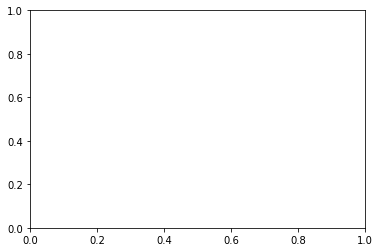

In [8]:
LABELS = ['ProviderID1','ProviderIDN'] #etc

#Produce the scatterplot as the answer to 2a
FIG, AX = plt.subplots()
AX.scatter(UNPAIDAGG, PAIDAGG)
AX.grid(linestyle='-', linewidth='0.75', color='red')

FIG = plt.gcf()
FIG.set_size_inches(25, 25)
plt.rcParams.update({'font.size': 28})

for i, TXT in enumerate(LABELS):
    AX.annotate(TXT, (UNPAIDAGG[I], PAIDAGG[I]))

plt.tick_params(labelsize=35)
plt.xlabel('# of Unpaid claims', fontsize=35)

plt.ylabel('# of Paid claims', fontsize=35)

plt.title('Scatterplot of Unpaid and Paid claims by Provider', fontsize=45)
plt.savefig('Paid_Unpaid_Scatterplot.png')

In [7]:
# # load into new arrays

# #format for sklearn
# label =  'IsUnpaid'
# cat_features = ['V1', 'ProviderID','LineOfBusinessID','RevenueCode',
#                 'ServiceCode', 'PlaceOfServiceCode', 'ProcedureCode',
#                 'DiagnosisCode', 'DenialReasonCode',
#                 'PriceIndex', 'InOutOfNetwork', 'ReferenceIndex', 
#                 'PricingIndex', 'CapitationIndex', 'ClaimSubscriberType',
#                 'ClaimPrePrinceIndex', 'ClaimCurrentStatus', 'NetworkID',
#                 'AgreementID', 'ClaimType', ]
# numeric_features = ['ClaimNumber', 'ClaimLineNumber', 'MemberID', 
#                     'ClaimChargeAmount',
#                     'SubscriberPaymentAmount', 'ProviderPaymentAmount',
#                     'GroupIndex', 'SubscriberIndex', 'SubgroupIndex']

# #convert features to list, then to np.array 
# # This step is important for sklearn to use the data from the structured NumPy array

# #separate categorical and numeric features. 
# #We put them into list and back into nparray again to reformat so Scikitlearn can see the columns
# Mcat = np.array(Jcodes_w_L[cat_features].tolist())
# Mnum = np.array(Jcodes_w_L[numeric_features].tolist())
# L = np.array(Jcodes_w_L[label].tolist())

# # first use Sklearn's LabelEncoder function ... then use the OneHotEncoder function
# # https://medium.com/@contactsunny/label-encoder-vs-one-hot-encoder-in-machine-learning-3fc273365621
# # http://www.stephacking.com/encode-categorical-data-labelencoder-onehotencoder-python/

# # Some claim you can do OnehotEncoder without a label encoder, but I haven't seen it work.
# # https://stackoverflow.com/questions/48929124/scikit-learn-how-to-compose-labelencoder-and-onehotencoder-with-a-pipeline

# # Run the Label encoder
# le = preprocessing.LabelEncoder()
# for i in range(20):
#    Mcat[:,i] = le.fit_transform(Mcat[:,i])

# # Run the OneHotEncoder
# # Could encounter a memory error here in which case, you probably should subset.
# ohe = OneHotEncoder(sparse=False) #Easier to read
# Mcat = ohe.fit_transform(Mcat)

# #What is the shape of the matrix categorical columns that were OneHotEncoded?   
# Mcat.shape
# Mnum.shape


# #I am subsetting them since I was having memory issues.
# #You might be able to decide which features are useful and remove some of them before
# # the label encoder and one hot encoding step

# #If you want to recover from the memory error then subset
# #Mcat = np.array(Jcodes_w_L[cat_features].tolist())

# Mcat_subset = Mcat[0:5000]
# Mcat=Mcat_subset

# Mnum_subset = Mnum[0:5000]
# Mnum=Mnum_subset

# L_subset = L[0:5000]
# L=L_subset

# # Uncomment if you need to run again from a subset.

# ## Run the Label encoder
# le = preprocessing.LabelEncoder()
# for i in range(20):
#    Mcat[:,i] = le.fit_transform(Mcat[:,i])

# # Run the OneHotEncoder
# # Could encounter a memory error here in which case, you probably should subset.
# ohe = OneHotEncoder(sparse=False) #Easier to read
# Mcat = ohe.fit_transform(Mcat)


# #What is the size in megabytes before subsetting?
# # https://www.w3resource.com/python-exercises/numpy/python-numpy-exercise-33.php
# # and using base2 (binary conversion), https://www.gbmb.org/bytes-to-mb
# print("%d Megabytes" % ((Mcat.size * Mcat.itemsize)/1048576))
# print("%d Megabytes" % ((Mnum.size * Mnum.itemsize)/1048576))

# #What is the size in megabytes after subsetting?
# print("%d Megabytes" % ((Mcat_subset.size * Mcat_subset.itemsize)/1048576)) 
# print("%d Megabytes" % ((Mnum_subset.size * Mnum_subset.itemsize)/1048576))


# M = np.concatenate((Mcat, Mnum), axis=1)



# #Concatenate the columns
# M = np.concatenate((Mcat_subset, Mnum_subset), axis=1)


# L = Jcodes_w_L[label].astype(int)

# # Match the label rows to the subset matrix rows.
# L = L[0:5000]

# M.shape
# L.shape

# # Now you can use your DeathToGridsearch code.


# n_folds = 5

# #EDIT: pack the arrays together into "data"
# data = (M,L,n_folds)





# #EDIT: A function, "run", to run all our classifiers against our data.

# def run(a_clf, data, clf_hyper={}):
#   M, L, n_folds = data #EDIT: unpack the "data" container of arrays
#   kf = KFold(n_splits=n_folds) # JS: Establish the cross validation 
#   ret = {} # JS: classic explicaiton of results
  
#   for ids, (train_index, test_index) in enumerate(kf.split(M, L)): #EDIT: We're interating through train and test indexes by using kf.split
#                                                                    #      from M and L.
#                                                                    #      We're simply splitting rows into train and test rows
#                                                                    #      for our five folds.
    
#     clf = a_clf(**clf_hyper) # JS: unpack paramters into clf if they exist   #EDIT: this gives all keyword arguments except 
#                                                                              #      for those corresponding to a formal parameter
#                                                                              #      in a dictionary.
            
#     clf.fit(M[train_index], L[train_index])   #EDIT: First param, M when subset by "train_index", 
#                                               #      includes training X's. 
#                                               #      Second param, L when subset by "train_index",
#                                               #      includes training Y.                             
    
#     pred = clf.predict(M[test_index])         #EDIT: Using M -our X's- subset by the test_indexes, 
#                                               #      predict the Y's for the test rows.
    
#     ret[ids]= {'clf': clf,                    #EDIT: Create arrays of
#                'train_index': train_index,
#                'test_index': test_index,
#                'accuracy': accuracy_score(L[test_index], pred)}    
#   return ret




# def populateClfAccuracyDict(results):
#     for key in results:
#         k1 = results[key]['clf'] 
#         v1 = results[key]['accuracy']
#         k1Test = str(k1) #Since we have a number of k-folds for each classifier...
#                          #We want to prevent unique k1 values due to different "key" values
#                          #when we actually have the same classifer and hyper parameter settings.
#                          #So, we convert to a string
                        
#         #String formatting            
#         k1Test = k1Test.replace('            ',' ') # remove large spaces from string
#         k1Test = k1Test.replace('          ',' ')
        
#         #Then check if the string value 'k1Test' exists as a key in the dictionary
#         if k1Test in clfsAccuracyDict:
#             clfsAccuracyDict[k1Test].append(v1) #append the values to create an array (techically a list) of values
#         else:
#             clfsAccuracyDict[k1Test] = [v1] #create a new key (k1Test) in clfsAccuracyDict with a new value, (v1)            
        
            

# def myHyperSetSearch(clfsList,clfDict):
#     #hyperSet = {}
#     for clf in clfsList:
    
#     #I need to check if values in clfsList are in clfDict
#         clfString = str(clf)
#         #print("clf: ", clfString)
        
#         for k1, v1 in clfDict.items(): # go through the inner dictionary of hyper parameters
#             #Nothing to do here, we need to get into the inner nested dictionary.
#             if k1 in clfString:
#                 #allows you to do all the matching key and values
#                 k2,v2 = zip(*v1.items()) # explain zip (https://docs.python.org/3.3/library/functions.html#zip)
#                 for values in product(*v2): #for the values in the inner dictionary, get their unique combinations from product()
#                     hyperSet = dict(zip(k2, values)) # create a dictionary from their values
#                     results = run(clf, data, hyperSet) # pass the clf and dictionary of hyper param combinations to run; get results
#                     populateClfAccuracyDict(results) # populate clfsAccuracyDict with results
 



# clfsList = [RandomForestClassifier] 

# clfDict = {'RandomForestClassifier': {"min_samples_split": [2,3,4], 
#                                       "n_jobs": [1,2,3]}}#,
                                      
#            #'LogisticRegression': {"tol": [0.001,0.01,0.1]}}

                   
# #Declare empty clfs Accuracy Dict to populate in myHyperSetSearch     
# clfsAccuracyDict = {}

# #Run myHyperSetSearch
# myHyperSetSearch(clfsList,clfDict)    

# print(clfsAccuracyDict)


# # for determining maximum frequency (# of kfolds) for histogram y-axis
# n = max(len(v1) for k1, v1 in clfsAccuracyDict.items())

# # for naming the plots
# filename_prefix = 'clf_Histograms_'

# # initialize the plot_num counter for incrementing in the loop below
# plot_num = 1 

# # Adjust matplotlib subplots for easy terminal window viewing
# left  = 0.125  # the left side of the subplots of the figure
# right = 0.9    # the right side of the subplots of the figure
# bottom = 0.1   # the bottom of the subplots of the figure
# top = 0.6      # the top of the subplots of the figure
# wspace = 0.2   # the amount of width reserved for space between subplots,
#                # expressed as a fraction of the average axis width
# hspace = 0.2   # the amount of height reserved for space between subplots,
#                # expressed as a fraction of the average axis height
               


# #create the histograms
# for k1, v1 in clfsAccuracyDict.items():
#     # for each key in our clfsAccuracyDict, create a new histogram with a given key's values 
#     fig = plt.figure(figsize =(20,10)) # This dictates the size of our histograms
#     ax  = fig.add_subplot(1, 1, 1) # As the ax subplot numbers increase here, the plot gets smaller
#     plt.hist(v1, facecolor='green', alpha=0.75) # create the histogram with the values
#     ax.set_title(k1, fontsize=30) # increase title fontsize for readability
#     ax.set_xlabel('Classifer Accuracy (By K-Fold)', fontsize=25) # increase x-axis label fontsize for readability
#     ax.set_ylabel('Frequency', fontsize=25) # increase y-axis label fontsize for readability
#     ax.xaxis.set_ticks(np.arange(0, 1.1, 0.1)) # The accuracy can only be from 0 to 1 (e.g. 0 or 100%)
#     ax.yaxis.set_ticks(np.arange(0, n+1, 1)) # n represents the number of k-folds
#     ax.xaxis.set_tick_params(labelsize=20) # increase x-axis tick fontsize for readability
#     ax.yaxis.set_tick_params(labelsize=20) # increase y-axis tick fontsize for readability
#     #ax.grid(True) # you can turn this on for a grid, but I think it looks messy here.

#     # pass in subplot adjustments from above.
#     plt.subplots_adjust(left=left, right=right, bottom=bottom, top=top, wspace=wspace, hspace=hspace)
#     plot_num_str = str(plot_num) #convert plot number to string
#     filename = filename_prefix + plot_num_str # concatenate the filename prefix and the plot_num_str
#     plt.savefig(filename, bbox_inches = 'tight') # save the plot to the user's working directory
#     plot_num = plot_num+1 # increment the plot_num counter by 1
    
# plt.show()



In [2]:
# -*- coding: utf-8 -*-
"""
Created on Sat Feb  9 16:32:16 2019
@author: Jeremy Lubich
Machine Learning HW2
"""

import numpy as np
# import numpy_groupies as npg
from tabulate import tabulate
from numpy.lib.recfunctions import append_fields
import matplotlib.pyplot as plt


## HW notes:
'''    
A medical claim is denoted by a claim number ('Claim.Number'). Each claim consists of one or more medical lines denoted by a claim line number ('Claim.Line.Number').

1. J-codes are procedure codes that start with the letter 'J'.
     A. Find the number of claim lines that have J-codes.
     B. How much was paid for J-codes to providers for 'in network' claims?
     C. What are the top five J-codes based on the payment to providers?

2. For the following exercises, determine the number of providers that were paid for at least one J-code. Use the J-code claims for these providers to complete the following exercises.
    A. Create a scatter plot that displays the number of unpaid claims (lines where the ‘Provider.Payment.Amount’ field is equal to zero) for each provider versus the number of paid claims.
    B. What insights can you suggest from the graph?
    C. Based on the graph, is the behavior of any of the providers concerning? Explain.

3. Consider all claim lines with a J-code.
     A. What percentage of J-code claim lines were unpaid?
     B. Create a model to predict when a J-code is unpaid. Explain why you choose the modeling approach.
     C. How accurate is your model at predicting unpaid claims?
     D. What data attributes are predominately influencing the rate of non-payment?
'''

types = ['S8', 'f8', 'i4', 'i4', 'S14', 'S6', 'S6', 'S6', 'S4', 'S9', 'S7', 'f8',
         'S5', 'S3', 'S3', 'S3', 'S3', 'S3', 'f8', 'f8', 'i4', 'i4', 'i4', 'S3', 
         'S3', 'S3', 'S4', 'S14', 'S14']




#creates array of structured arrays
claims_data = np.genfromtxt(
    'claim.sample.csv', 
    dtype=types, 
    delimiter=',', 
    names=True, 
    usecols=np.arange(0,29))

print('Length of all claims records')
len(claims_data)

test = 'J'
test = test.encode()

#Example of substring searching
np.core.defchararray.find(claims_data['ProcedureCode'],test)

#We want the ProcedureCodes which start with J 
JcodeIndexes = np.flatnonzero(np.core.defchararray.find(claims_data['ProcedureCode'],test)==1)

print('**********************************************')
print('Question 1 - A: 51029 claim lines with a J-Code')
print(len(JcodeIndexes))
print('**********************************************')

##########################################################################
# B: How much was paid for J-codes to providers for 'in network' claims?
##########################################################################

#Using those indexes, subset to only Jcodes
claims_data_jcodes = claims_data[JcodeIndexes]
len(claims_data_jcodes)

## Here are all of the column names for reference
#print(claims_data_jcodes.dtype.names)
#print(claims_data_jcodes.dtype)

'''
('V1', 'ClaimNumber', 'ClaimLineNumber', 'MemberID', 'ProviderID', 'LineOfBusinessID', 
'RevenueCode', 'ServiceCode', 'PlaceOfServiceCode', 'ProcedureCode', 'DiagnosisCode', 
'ClaimChargeAmount', 'DenialReasonCode', 'PriceIndex', 'InOutOfNetwork', 'ReferenceIndex', 
'PricingIndex', 'CapitationIndex', 'SubscriberPaymentAmount', 'ProviderPaymentAmount', 
'GroupIndex', 'SubscriberIndex', 'SubgroupIndex', 'ClaimType', 'ClaimSubscriberType', 
'ClaimPrePrinceIndex', 'ClaimCurrentStatus', 'NetworkID', 'AgreementID')
'''

## Valid values are I and O
np.unique(claims_data_jcodes['InOutOfNetwork'])

## Get all of the "In-network" claims
in_network_index = np.flatnonzero(np.core.defchararray.find(claims_data_jcodes['InOutOfNetwork'],'I'.encode())==1)

print('**********************************************')
print('Question 1 - B: $2,417,220.96 paid to in-network providers')
print(claims_data_jcodes[in_network_index]['ProviderPaymentAmount'].sum().round(2))
print('**********************************************')

##########################################################################
# C: What are the top five J-codes based on the payment to providers?
##########################################################################

#Create a dictionary of all the JCodes and their ID number
jcode_to_index_dict = {ni : indi for indi, ni in enumerate(set(claims_data_jcodes['ProcedureCode']))}
jcode_to_name_dict = {indi : ni for indi, ni in enumerate(set(claims_data_jcodes['ProcedureCode']))}

#Loop through all rows and lookup the jcode_index
jcode_ids = [jcode_to_index_dict[ni] for ni in claims_data_jcodes['ProcedureCode']]

## Make sure both dictionaries return the same stuff.
jcode_to_name_dict[1]
jcode_to_index_dict[b'"J2597"']

## Create 1 sum per procedure code
sum_per_jcode_id = npg.aggregate(jcode_ids, claims_data_jcodes['ProviderPaymentAmount'], func='sum')

## Zip together the jcode id, the original jcode name and the sum
zipped = zip(jcode_ids, jcode_to_name_dict.values(), sum_per_jcode_id) 

## Sort based on the sum amount descending
sorted_group_sums = sorted(zipped, key=lambda x: x[2], reverse=True)

print('**********************************************')
print('Question 1 - C: top five J-codes based on the payment to providers')
print(tabulate(sorted_group_sums[0:5], headers=['JCode_ID', 'JCode', 'SumProviderPaymentAmount']))
print('**********************************************')

##########################################################################
# 2. For the following exercises, determine the number of providers that 
#  were paid for at least one J-code. Use the J-code claims for these providers 
# to complete the following exercises.
##########################################################################

## Find all "paid" providers
paid_providers = np.unique(claims_data_jcodes[np.where(claims_data_jcodes['ProviderPaymentAmount'] > 0)]['ProviderID'])

## Get all of the claim lines for these "paid" providers
claims_data_jcodes_paid = claims_data_jcodes[np.where(np.isin(claims_data_jcodes['ProviderID'], paid_providers))]

## Create the isPaid columns
claims_data_jcodes_paid = append_fields(claims_data_jcodes_paid, 'isPaid', claims_data_jcodes_paid['ProviderPaymentAmount'] > 0)
claims_data_jcodes_paid = append_fields(claims_data_jcodes_paid, 'isPaidCount', (claims_data_jcodes_paid['ProviderPaymentAmount'] > 0) + 0)
claims_data_jcodes_paid = append_fields(claims_data_jcodes_paid, 'isNotPaidCount', (claims_data_jcodes_paid['ProviderPaymentAmount'] == 0) + 0)

## There were 51,029 claim lines for JCodes
len(claims_data_jcodes)
## There are 51,015 claim lines for providers with one or more paid JCodes
len(claims_data_jcodes_paid)

## There are 44,947 unpaid claims and 6,068 paid ones
isPaidNames, isPaidValues = np.unique(claims_data_jcodes_paid['isPaid'], return_counts=True)

print('**********************************************')
print('Question 2: How many claims are there for paid providers...')
print(len(claims_data_jcodes_paid))
print('Question 2: How many paid claims are there? isPaid = ...')
print(tabulate([isPaidValues], headers=isPaidNames.data))
print('**********************************************')

##########################################################################
# A. Create a scatter plot that displays the number of unpaid claims (lines 
#     where the ‘Provider.Payment.Amount’ field is equal to zero) for each provider 
#     versus the number of paid claims.
##########################################################################

#Create a dictionary of all the Providers and their ID number
provider_to_index_dict = {ni : indi for indi, ni in enumerate(set(claims_data_jcodes_paid['ProviderID']))}

#Loop through all rows and lookup the jcode_index so we can group by ids
provider_ids = [provider_to_index_dict[ni] for ni in claims_data_jcodes_paid['ProviderID']]

# Group by provider ids getting paid and not paid counts
sum_per_provider_paid = npg.aggregate(provider_ids, claims_data_jcodes_paid['isPaidCount'], func='sum')
sum_per_provider_not_paid = npg.aggregate(provider_ids, claims_data_jcodes_paid['isNotPaidCount'], func='sum')

## Zip together the original provider name and the sums
provider_sums = zip(provider_to_index_dict.keys(), sum_per_provider_paid, sum_per_provider_not_paid, (sum_per_provider_paid + sum_per_provider_not_paid), sum_per_provider_paid / (sum_per_provider_paid + sum_per_provider_not_paid)) 

## Sort based on the sum amount descending
provider_sums = sorted(provider_sums, key=lambda x: x[3], reverse=True)


#####################################################
## Create Scatterplot
fig, ax = plt.subplots()
fig.set_size_inches(12.5, 5.5)

# Plot each provider value
for provider in provider_sums:
  ax.scatter(provider[1], provider[2], label='Provider:' + provider[0].decode(), edgecolors='none')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.grid(True)

# Add a slope line??
plt.plot([0, 1775],[0,14000])

plt.title('Scatterplot 1 - Claims Paid by Provider')
plt.xlabel('Paid Claims')
plt.ylabel('Not Paid Claims')
plt.show()
#####################################################

### Sort based on the ratio amount descending
#provider_paid_ratio = sorted(zip([x[0].decode() for x in provider_sums], [x[1] / x[3] for x in provider_sums]), key=lambda x: x[1], reverse=True)
#providers_sorted = [x[0] for x in provider_paid_ratio]
#providers_paid_ratio_sorted = [x[1] for x in provider_paid_ratio]

######################################################
### Create Barchart
#fig, ax = plt.subplots()
#fig.set_size_inches(12.5, 5.5)
#
#ticklabels = []
#
## Plot each provider value
#for i, provider in enumerate(provider_paid_ratio):
#  ticklabels.append(provider[0])
#  ax.bar(i, provider[1], label='Provider:' + provider[0])
#
## Shrink current axis by 20%
#box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
#
## Put a legend to the right of the current axis
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#
#ax.grid(True)
#ax.set_xticks(np.arange(len(ticklabels)))
#ax.set_xticklabels(ticklabels, rotation=90)
#
#
#plt.title('Percent of Claims Paid by Provider')
#plt.xlabel('Providers')
#plt.ylabel('Percent of Paid Claims')
#plt.show()
######################################################

print('**********************************************')
print('Question 2 - B. What insights can you suggest from the graph?')
print('We see there are a mixture of types of providers who pay payments. Some providers have a very small amount of claims and tend to pay them, while many other providers have a large number of claims and seem to pay a small percentage of them.')
print('I\ve added a line which bisects the top performers from the bottom performers. In this case, its those on the lower side of the line which are paying in a greater percentage of claims than not based on a comparison of their peers.')
print('**********************************************')

#####################################################
## Create 2nd Scatterplot
fig, ax = plt.subplots()
fig.set_size_inches(12.5, 5.5)

# Plot each provider value
for provider in provider_sums:
  ax.scatter(provider[3], provider[4], label='Provider:' + provider[0].decode(), edgecolors='none')
  ax.text(provider[3], provider[4], provider[0].decode(), fontsize=9)
  
  
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.grid(True)

plt.title('Scatterplot 2 - Percent Claims Paid by Provider')
plt.xlabel('Total Claims Submitted')
plt.ylabel('Percent Claims Paid')
plt.show()
#####################################################

print('**********************************************')
print('Question 2 - C. Based on the graph, is the behavior of any of the providers concerning? Explain.')
print('I\'ve created an additional scatterplot to help us analyze the performance of the providers which are not providing a good rate of claim payments.')
print('Along the x axis you see the total number of claims submitted and the percentage of claims paid on the y axis.')
print('The scatterplot naturally groups providers into 3 clusters. ')
print('Cluster 1 on the lower left are the providers with a relatively low amount of claims and a low percentage of paying them.')
print('Cluster 2 on the upper left are the providers with a relatively low amount of claims and a high percentage of paying them.')
print('Cluster 3 on the lower right are the providers with a relatively high amount of claims and a high percentage of paying them.')
print('The most concerning provider is "FA0001387001" who has nearly 9k claims, but has paid nearly none of them. This provider is outlier amount the 4 big providers (Cluster 3) who have the most claims.')
print('**********************************************')

#3. Consider all claim lines with a J-code.
#     A. What percentage of J-code claim lines were unpaid?
#     B. Create a model to predict when a J-code is unpaid. Explain why you choose the modeling approach.
#     C. How accurate is your model at predicting unpaid claims?
#     D. What data attributes are predominately influencing the rate of non-payment?
     

ModuleNotFoundError: No module named 'tabulate'